## 1. Import pakages

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import os
import tqdm
import requests
from datetime import datetime, timedelta, date
import time

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

import lightgbm as lgb

In [2]:
def get_calendar_data(start_year, end_year, country):
    dfs = []

    for year in tqdm.tqdm(range(start_year, end_year + 1), desc="Fetching Data"):
        url = f"https://www.timeanddate.com/holidays/{country}/{year}"
        html_result = pd.read_html(url)
        calendar = html_result[0]

        if calendar.shape[1] == 4:
            calendar.columns = ['Date', 'Weekday', 'Name', 'Details']
        elif calendar.shape[1] == 5:
            calendar.columns = ['Date', 'Weekday', 'Name', 'Type', 'Details']

        calendar = calendar.dropna(how='all', axis=0).reset_index(drop=True)
        calendar['Year'] = year

        # Merge "Date" and "Year" columns into datetime format
        calendar['Date'] = calendar['Date'] + ' ' + calendar['Year'].astype(str)
        
        try:
            calendar['Date'] = pd.to_datetime(calendar['Date'], format='%b %d %Y')
        except:
            calendar['Date'] = pd.to_datetime(calendar['Date'], format='%d %b %Y')
        dfs.append(calendar)

    concatenated_df = pd.concat(dfs, ignore_index=True)
    concatenated_df = concatenated_df.drop('Year', axis=1)
    return concatenated_df

## 2. Data reading and preprocessing

In [3]:
path_data = r'C:\Users\user\TaipowerTalk2023\data'

path_data_loadarea = os.path.join(path_data, 'loadarea')
path_data_forecast = os.path.join(path_data, 'forecast')

### 2.1 Energy data

In [4]:
loadarea = []

for file in tqdm.tqdm(os.listdir(path_data_loadarea)):
    df_temp = pd.read_csv(os.path.join(path_data_loadarea, file))
    loadarea.append(df_temp)

loadarea = pd.concat(loadarea, axis=0, ignore_index=True)
loadarea = loadarea.pivot_table(columns='area',index='datetime',values='load')
loadarea.index= pd.to_datetime(loadarea.index)
loadarea.columns = 'load_'+loadarea.columns

loadarea['load_total'] = loadarea['load_north']+ loadarea['load_east']+ loadarea['load_central']+ loadarea['load_south']

loadarea

100%|████████████████████████████████████████████████████████████████████████████| 1946/1946 [00:01<00:00, 1057.87it/s]


area,load_central,load_east,load_north,load_south,load_total
datetime,,,,,
2017-01-01 00:00:00,567.0,33.2,677.8,696.2,1974.2
2017-01-01 00:10:00,553.1,32.9,671.6,695.2,1952.8
2017-01-01 00:20:00,568.2,33.3,672.2,695.1,1968.8
2017-01-01 00:30:00,553.2,33.6,672.4,684.3,1943.5
2017-01-01 00:40:00,563.7,32.6,658.2,696.6,1951.1
...,...,...,...,...,...
2022-07-01 23:10:00,951.4,43.9,1139.3,1056.0,3190.6
2022-07-01 23:20:00,941.5,43.7,1125.7,1055.6,3166.5
2022-07-01 23:30:00,928.8,43.2,1125.1,1053.4,3150.5


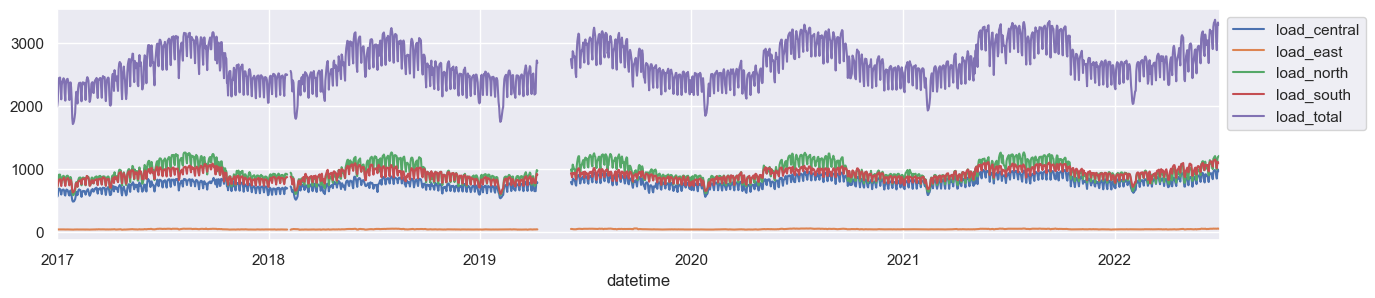

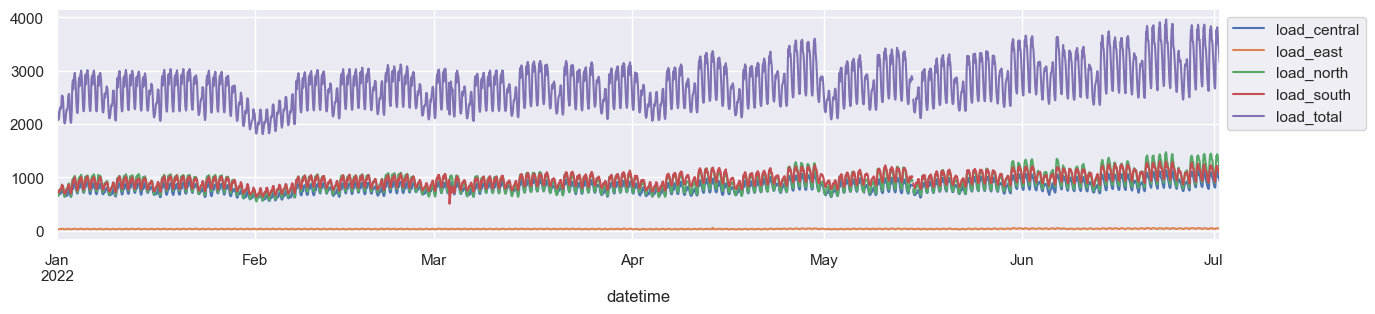

In [5]:
#loadarea.resample('D').mean().iplot()
#loadarea.loc['2020':].resample('H').mean().iplot()
loadarea.resample('D').mean().plot(figsize=(15,3))
plt.legend(bbox_to_anchor=(1.00, 1.00))
loadarea.loc['2022':].resample('H').mean().plot(figsize=(15,3))
plt.legend(bbox_to_anchor=(1.00, 1.00))

### 2.2 Weather data

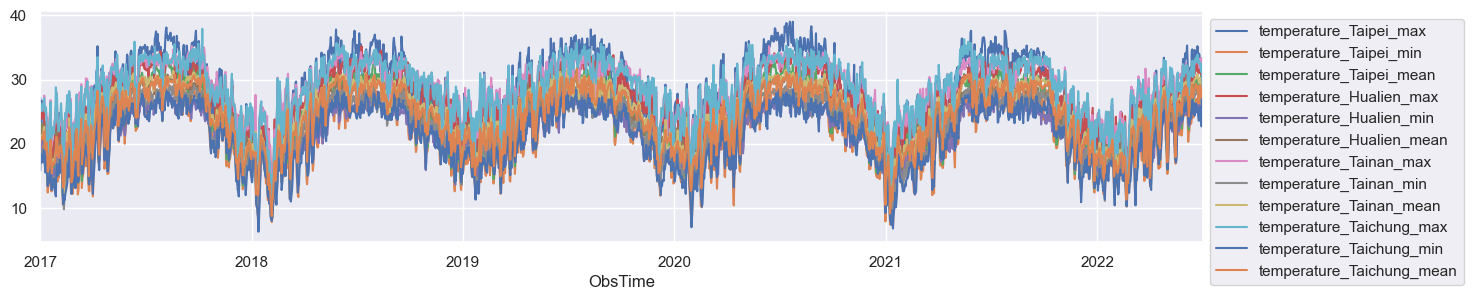

In [6]:
weatherData = pd.read_csv(os.path.join(path_data, 'weatherData_20170101-20220701.csv'), encoding='utf8')
temperatureData = weatherData.pivot_table(index='ObsTime',columns='station',values='Temperature')
temperatureData = temperatureData.rename(columns={'466920_臺北':'Taipei','466990_花蓮':'Hualien',
                                                  '467410_臺南':'Tainan','467490_臺中':'Taichung'})
temperatureData.index = pd.to_datetime(temperatureData.index)
temperatureData.columns = 'temperature_'+temperatureData.columns
temperatureData = temperatureData.resample('D').agg(['max','min','mean'])
temperatureData.columns = temperatureData.columns.get_level_values(0)+'_'+temperatureData.columns.get_level_values(1)

#temperatureData.iplot()
temperatureData.plot(figsize=(15,3))
plt.legend(bbox_to_anchor=(1.00, 1.00))

In [7]:
weatherData = pd.read_csv(os.path.join(path_data, 'weatherData_20170101-20220701.csv'), encoding='utf8')
temperatureData_10mins = weatherData.pivot_table(index='ObsTime',columns='station',values='Temperature')
temperatureData_10mins = temperatureData_10mins.rename(columns={'466920_臺北':'Taipei','466990_花蓮':'Hualien',
                                                  '467410_臺南':'Tainan','467490_臺中':'Taichung'})
temperatureData_10mins.index = pd.to_datetime(temperatureData_10mins.index)
temperatureData_10mins.columns = 'temperature_'+temperatureData_10mins.columns
temperatureData_10mins = temperatureData_10mins.resample('10T').interpolate()

temperatureData_10mins

station,temperature_Taipei,temperature_Hualien,temperature_Tainan,temperature_Taichung
ObsTime,,,,
2017-01-01 01:00:00,20.500000,18.900000,18.600000,17.500000
2017-01-01 01:10:00,20.533333,18.916667,18.566667,17.416667
2017-01-01 01:20:00,20.566667,18.933333,18.533333,17.333333
2017-01-01 01:30:00,20.600000,18.950000,18.500000,17.250000
2017-01-01 01:40:00,20.633333,18.966667,18.466667,17.166667
...,...,...,...,...
2022-07-01 23:20:00,28.966667,25.600000,26.966667,27.466667
2022-07-01 23:30:00,28.900000,25.600000,27.000000,27.500000
2022-07-01 23:40:00,28.833333,25.600000,27.033333,27.533333


### 2.3 Calendar data

In [8]:
calendar_tw = get_calendar_data(2017, 2022, 'taiwan')
calendar_tw

Fetching Data: 100%|█████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.17it/s]


,Date,Weekday,Name,Details
0,2017-01-01,Sunday,Republic Day/New Year's Day,National holiday
1,2017-01-02,Monday,Republic Day/New Year's Day observed,National holiday
2,2017-01-27,Friday,Lunar New Year's Eve,National holiday
3,2017-01-28,Saturday,Lunar New Year's Day,National holiday
4,2017-01-29,Sunday,Lunar New Year Holiday,National holiday
...,...,...,...,...
314,2022-11-12,Saturday,Sun Yat-sen's Birthday,Observance
315,2022-12-22,Thursday,December Solstice,Season
316,2022-12-22,Thursday,Dōngzhì Festival,Observance
317,2022-12-25,Sunday,Constitution Day,Observance


In [9]:
df_holiday = calendar_tw[['Date', 'Name', 'Details']]
df_holiday = df_holiday[df_holiday['Details'].isin(['National holiday', 'Working day on weekend'])]
df_holiday.columns = 'Date '+df_holiday.columns
df_holiday = df_holiday.rename(columns={'Date Date':'Date'})
df_holiday

,Date,Date Name,Date Details
0,2017-01-01,Republic Day/New Year's Day,National holiday
1,2017-01-02,Republic Day/New Year's Day observed,National holiday
2,2017-01-27,Lunar New Year's Eve,National holiday
3,2017-01-28,Lunar New Year's Day,National holiday
4,2017-01-29,Lunar New Year Holiday,National holiday
...,...,...,...
286,2022-04-05,Tomb Sweeping Day,National holiday
295,2022-06-03,Dragon Boat Festival,National holiday
304,2022-09-09,Mid-Autumn Festival Holiday,National holiday
305,2022-09-10,Mid-Autumn Festival,National holiday


In [10]:
df_holiday['Date'] = pd.to_datetime(df_holiday['Date'])
df_holiday = df_holiday.drop_duplicates(subset='Date')
df_holiday = df_holiday.set_index('Date').asfreq('D')
df_holiday = df_holiday.reset_index()

df_holiday.loc[(df_holiday['Date'].dt.weekday<=4)&(df_holiday['Date Name'].isna()), 'Date Name'] = 'Regular workday'
df_holiday['Date Name'] = df_holiday['Date Name'].fillna('Weekends')

df_holiday['Date Name_encoding'] = df_holiday['Date Name'].rank()

df_holiday.loc[df_holiday['Date Details'].isna(), 'Date Details'] = df_holiday.loc[df_holiday['Date Details'].isna(), 'Date Name']

df_holiday['Date Details_encoding'] = preprocessing.LabelEncoder().fit_transform(df_holiday['Date Details'].astype('str'))


df_holiday

,Date,Date Name,Date Details,Date Name_encoding,Date Details_encoding
0,2017-01-01,Republic Day/New Year's Day,National holiday,1517.5,0
1,2017-01-02,Republic Day/New Year's Day observed,National holiday,1521.5,0
2,2017-01-03,Regular workday,Regular workday,798.0,1
3,2017-01-04,Regular workday,Regular workday,798.0,1
4,2017-01-05,Regular workday,Regular workday,798.0,1
...,...,...,...,...,...
2104,2022-10-06,Regular workday,Regular workday,798.0,1
2105,2022-10-07,Regular workday,Regular workday,798.0,1
2106,2022-10-08,Weekends,Weekends,1822.5,2
2107,2022-10-09,Weekends,Weekends,1822.5,2


### 2.4 Merge datasets and create features

In [11]:
df_dataset = loadarea.copy()


index_temp = df_dataset.index.copy()

df_dataset['date'] = pd.to_datetime(df_dataset.index.date)
df_dataset.index = df_dataset.index.round('10T')
df_dataset['year'] = df_dataset.index.year.astype('int')
df_dataset['weekday'] = df_dataset.index.weekday
df_dataset['hour'] = df_dataset.index.hour + df_dataset.index.minute/60
df_dataset['timeofweek'] = df_dataset['hour'] + df_dataset['weekday']*24

df_dataset = df_dataset.merge(temperatureData_10mins.reset_index(), left_on='datetime', right_on='ObsTime', how='left')
df_dataset = df_dataset.merge(temperatureData.reset_index(), left_on='date', right_on='ObsTime')

df_dataset = df_dataset.merge(df_holiday, left_on='date', right_on='Date')
#df_dataset = df_dataset.drop('date',axis=1)
df_dataset.index = index_temp

df_dataset['temperature_mean']=df_dataset[['temperature_Taipei_mean', 'temperature_Tainan_mean', 'temperature_Taichung_mean']].mean(axis=1)
df_dataset['temperature']=df_dataset[['temperature_Taipei', 'temperature_Tainan', 'temperature_Taichung']].mean(axis=1)

df_dataset

,load_central,load_east,load_north,load_south,load_total,date,year,weekday,hour,timeofweek,...,temperature_Taichung_max,temperature_Taichung_min,temperature_Taichung_mean,Date,Date Name,Date Details,Date Name_encoding,Date Details_encoding,temperature_mean,temperature
datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,567.0,33.2,677.8,696.2,1974.2,2017-01-01,2017,6,0.000000,144.000000,...,25.6,15.8,20.047826,2017-01-01,Republic Day/New Year's Day,National holiday,1517.5,0,21.243478,NaN
2017-01-01 00:10:00,553.1,32.9,671.6,695.2,1952.8,2017-01-01,2017,6,0.166667,144.166667,...,25.6,15.8,20.047826,2017-01-01,Republic Day/New Year's Day,National holiday,1517.5,0,21.243478,NaN
2017-01-01 00:20:00,568.2,33.3,672.2,695.1,1968.8,2017-01-01,2017,6,0.333333,144.333333,...,25.6,15.8,20.047826,2017-01-01,Republic Day/New Year's Day,National holiday,1517.5,0,21.243478,NaN
2017-01-01 00:30:00,553.2,33.6,672.4,684.3,1943.5,2017-01-01,2017,6,0.500000,144.500000,...,25.6,15.8,20.047826,2017-01-01,Republic Day/New Year's Day,National holiday,1517.5,0,21.243478,NaN
2017-01-01 00:40:00,563.7,32.6,658.2,696.6,1951.1,2017-01-01,2017,6,0.666667,144.666667,...,25.6,15.8,20.047826,2017-01-01,Republic Day/New Year's Day,National holiday,1517.5,0,21.243478,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01 23:10:00,951.4,43.9,1139.3,1056.0,3190.6,2022-07-01,2022,4,23.166667,119.166667,...,32.3,26.5,28.604167,2022-07-01,Regular workday,Regular workday,798.0,1,29.218056,27.8
2022-07-01 23:20:00,941.5,43.7,1125.7,1055.6,3166.5,2022-07-01,2022,4,23.333333,119.333333,...,32.3,26.5,28.604167,2022-07-01,Regular workday,Regular workday,798.0,1,29.218056,27.8
2022-07-01 23:30:00,928.8,43.2,1125.1,1053.4,3150.5,2022-07-01,2022,4,23.500000,119.500000,...,32.3,26.5,28.604167,2022-07-01,Regular workday,Regular workday,798.0,1,29.218056,27.8


## 3. Modeling

### 3.1 Our first model: temporal and weather feature

<Axes: xlabel='timeofweek', ylabel='load_total'>

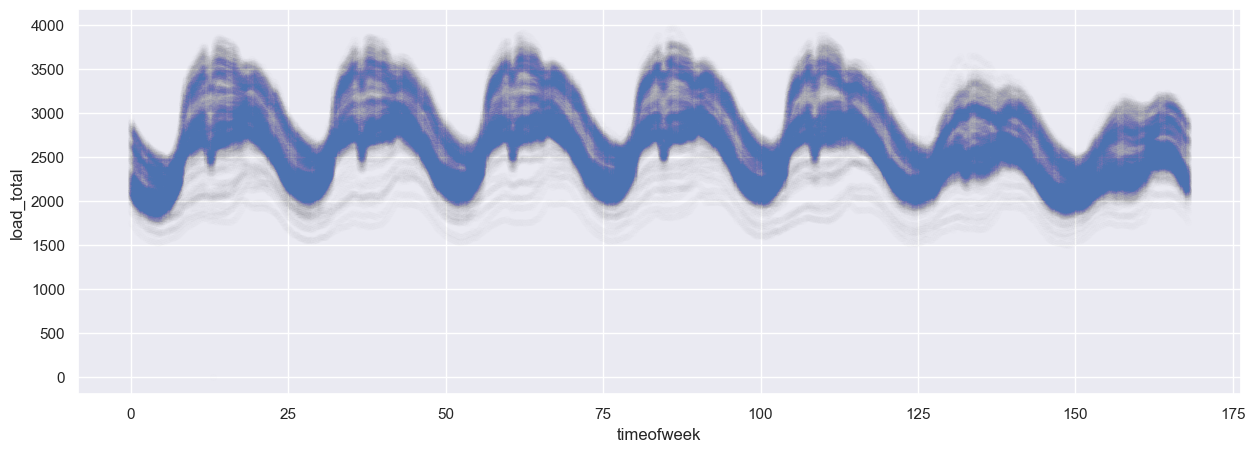

In [12]:
df_dataset.plot(kind='scatter',x='timeofweek',y='load_total', figsize=(15,5),alpha=0.005)

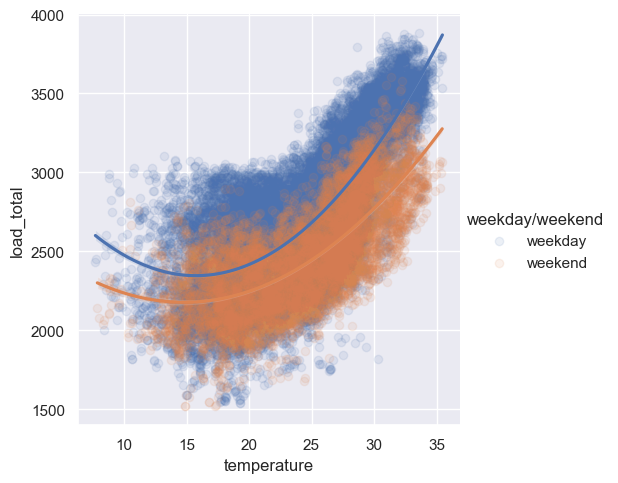

In [13]:
# Scatter plot for demand and outdoor temperature
df_plot = df_dataset.sample(frac=0.1, random_state=42).copy()
df_plot['weekday/weekend'] = 'weekday'
df_plot.loc[df_plot['weekday']>4, 'weekday/weekend'] ='weekend'

sns.lmplot(x='temperature', y='load_total', hue="weekday/weekend",
           data=df_plot, order=2, scatter_kws={'alpha':0.1})

C:\Users\user\AppData\Local\Temp\ipykernel_24128\3570258074.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_plot = df_dataset.resample('D').mean().copy()


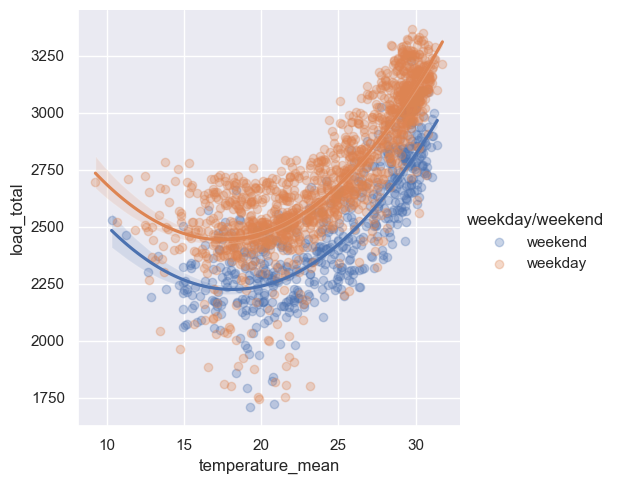

In [14]:
# Scatter plot for demand and outdoor temperature
df_plot = df_dataset.resample('D').mean().copy()
df_plot['weekday/weekend'] = 'weekday'
df_plot.loc[df_plot['weekday']>4, 'weekday/weekend'] ='weekend'

sns.lmplot(x='temperature_mean', y='load_total', hue="weekday/weekend",
           data=df_plot, order=2, scatter_kws={'alpha':0.3})

C:\Users\user\AppData\Local\Temp\ipykernel_24128\1704991988.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_plot = df_dataset.resample('D').mean().copy()
C:\Users\user\anaconda3\lib\site-packages\seaborn\algorithms.py:98: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\user\anaconda3\lib\site-packages\seaborn\algorithms.py:98: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\user\anaconda3\lib\site-packages\seaborn\algorithms.py:98: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\user\anaconda3\lib\site-packages\seaborn\algorithms.py:98: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
C:

(1500.0, 3500.0)

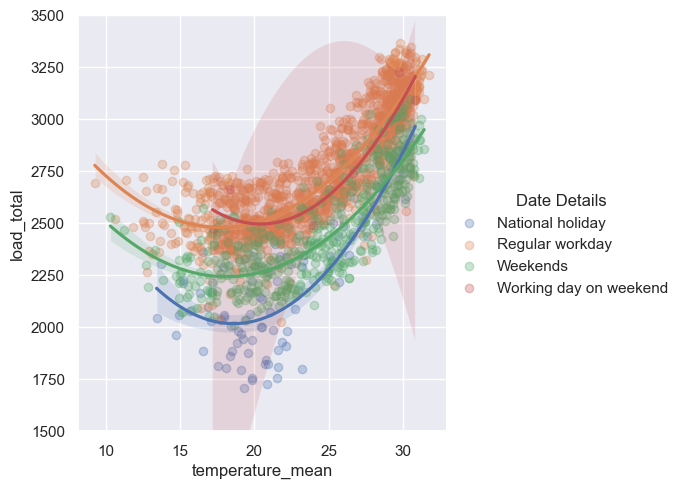

In [15]:
# Scatter plot for demand and outdoor temperature
df_plot = df_dataset.resample('D').mean().copy()
df_plot_text = df_dataset.select_dtypes('object').resample('D').first().copy()
df_plot = pd.concat([df_plot, df_plot_text],axis=1)

sns.lmplot(x='temperature_mean', y='load_total', hue="Date Details",
           data=df_plot, order=2, scatter_kws={'alpha':0.3})
plt.ylim(1500,3500)

In [16]:
list_feat = ['weekday','hour','temperature_mean', 'temperature']

R SQUARED: 0.701
MAE: 213.338


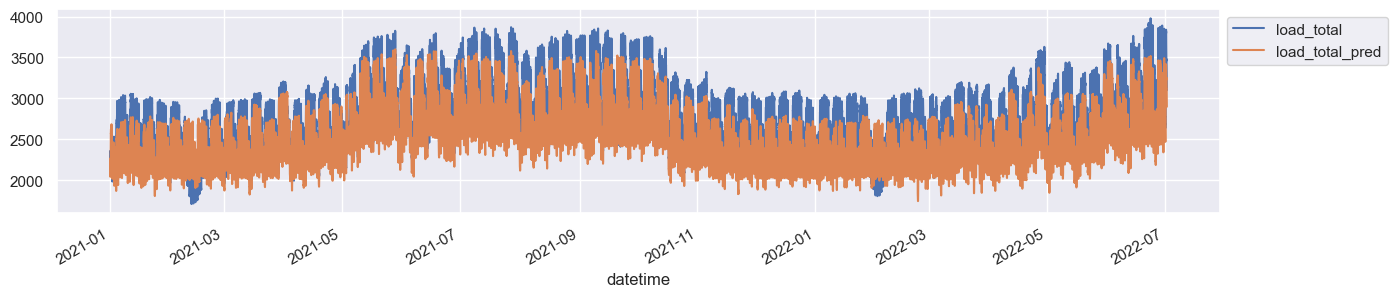

In [17]:
traindata = df_dataset.loc[:'2020'].copy()
testdata = df_dataset.loc['2021':].copy()

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['load_total'])

testdata['load_total_pred'] = LGB_model.predict(testdata[list_feat])

errors = abs(testdata['load_total_pred'] - testdata['load_total'])

RSQUARED = r2_score(testdata['load_total'], testdata['load_total_pred'])
MAE = mean_absolute_error(testdata['load_total'], testdata['load_total_pred'])

print("R SQUARED: "+str(round(RSQUARED,3)))
print("MAE: "+str(round(MAE,3)))

#testdata[['load_total', 'load_total_pred']].iplot()
testdata[['load_total', 'load_total_pred']].plot(figsize=(15,3))
plt.legend(bbox_to_anchor=(1.00, 1.00))

### 3.2 The 2nd model: add calendar data

C:\Users\user\AppData\Local\Temp\ipykernel_24128\290671171.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_plot = df_dataset.resample('D').mean().copy()
C:\Users\user\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 93.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 86.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 31.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.w

<Axes: xlabel='load_total', ylabel='Date Name'>

C:\Users\user\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 92.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 82.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 6.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


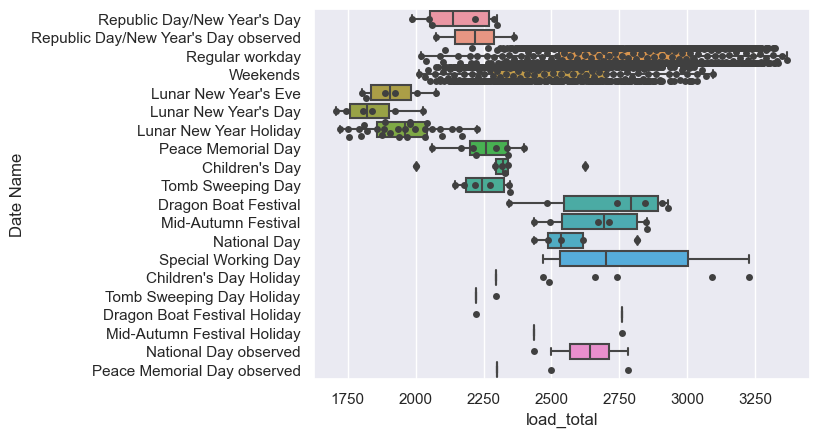

In [18]:
# Scatter plot for demand and Google Trend
df_plot = df_dataset.resample('D').mean().copy()
df_plot_text = df_dataset.select_dtypes('object').resample('D').first().copy()
df_plot = pd.concat([df_plot, df_plot_text],axis=1)

sns.boxplot(y="Date Name", x='load_total', data=df_plot)
sns.swarmplot(y="Date Name", x='load_total', data=df_plot, color=".25")

C:\Users\user\AppData\Local\Temp\ipykernel_24128\866811628.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_plot = df_dataset.resample('D').mean().copy()
C:\Users\user\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 71.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 44.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='load_total', ylabel='Date Details'>

C:\Users\user\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 67.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 35.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


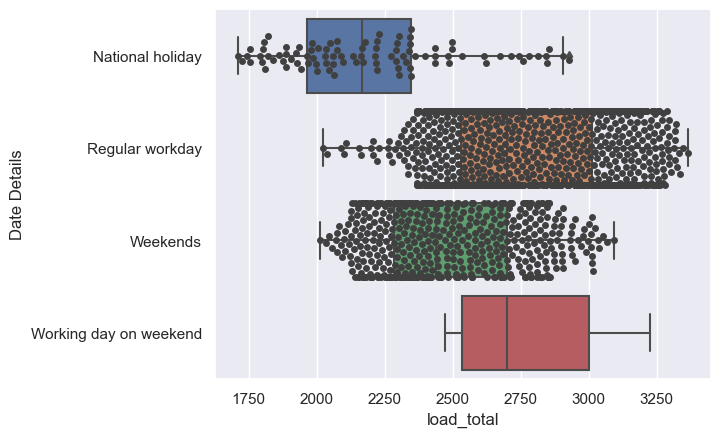

In [19]:
# Scatter plot for demand and Google Trend
df_plot = df_dataset.resample('D').mean().copy()
df_plot_text = df_dataset.select_dtypes('object').resample('D').first().copy()
df_plot = pd.concat([df_plot, df_plot_text],axis=1)

sns.boxplot(y="Date Details", x='load_total', data=df_plot)
sns.swarmplot(y="Date Details", x='load_total', data=df_plot, color=".25")

In [20]:
list_feat = ['weekday','hour','temperature_mean', 'temperature',
             'Date Name_encoding',
             "Date Details_encoding",
            ]

R SQUARED: 0.764
MAE: 193.568


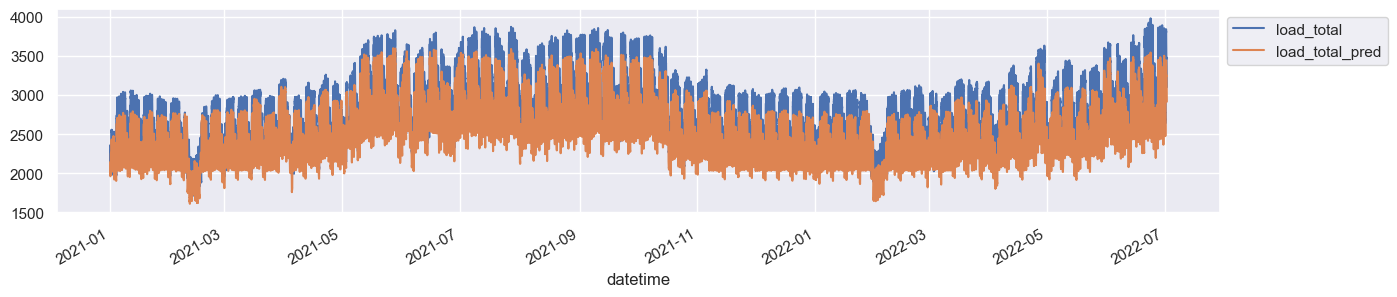

In [21]:
traindata = df_dataset.loc[:'2020'].copy()
testdata = df_dataset.loc['2021':].copy()

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['load_total'])

testdata['load_total_pred'] = LGB_model.predict(testdata[list_feat])

errors = abs(testdata['load_total_pred'] - testdata['load_total'])

RSQUARED = r2_score(testdata['load_total'], testdata['load_total_pred'])
MAE = mean_absolute_error(testdata['load_total'], testdata['load_total_pred'])

print("R SQUARED: "+str(round(RSQUARED,3)))
print("MAE: "+str(round(MAE,3)))

#testdata[['load_total', 'load_total_pred']].iplot()
testdata[['load_total', 'load_total_pred']].plot(figsize=(15,3))
plt.legend(bbox_to_anchor=(1.00, 1.00))

### 3.3 The 3rd model: add growth rate

C:\Users\user\AppData\Local\Temp\ipykernel_24128\2372501311.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_plot = df_dataset.resample('D').mean().copy()


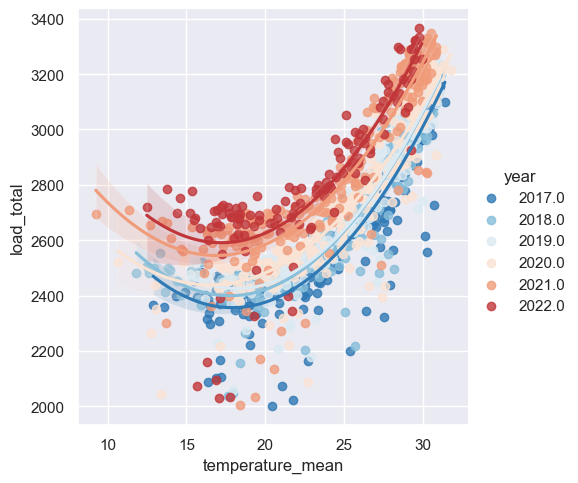

In [22]:
df_plot = df_dataset.resample('D').mean().copy()
df_plot['weekday/weekend'] = 'weekday'
df_plot.loc[df_plot['weekday']>4, 'weekday/weekend'] ='weekend'
df_plot = df_plot[df_plot['weekday/weekend']=='weekday']
df_plot = df_plot[df_plot['load_total']>2000]

sns.lmplot(x='temperature_mean', y='load_total', hue='year',
           data=df_plot, order=2, palette='RdBu_r')

In [23]:
growth_rate = 0.025

In [24]:
df_dataset['delta_time'] = df_dataset.index.year + df_dataset.index.dayofyear/366 + df_dataset.index.hour/366/24
df_dataset['delta_time'] = df_dataset['delta_time'] - df_dataset['delta_time'].min()

df_dataset['load_total_untrended'] = df_dataset['load_total'] * (1-growth_rate*df_dataset['delta_time'])

In [25]:
list_feat = ['weekday','hour','temperature_mean', 'temperature',
             'Date Name_encoding',
             "Date Details_encoding",
            ]

R SQUARED: 0.969
MAE: 54.252


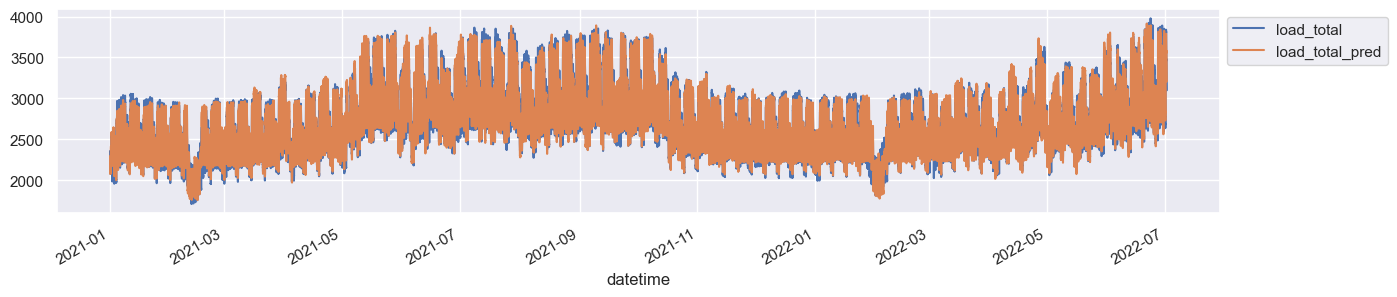

In [26]:
traindata = df_dataset.loc[:'2020'].copy()
testdata = df_dataset.loc['2021':].copy()


LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['load_total_untrended'])

testdata['load_total_pred'] = LGB_model.predict(testdata[list_feat])
testdata['load_total_pred'] = testdata['load_total_pred'] / (1-growth_rate*testdata['delta_time'])

errors = abs(testdata['load_total_pred'] - testdata['load_total'])

RSQUARED = r2_score(testdata['load_total'], testdata['load_total_pred'])
MAE = mean_absolute_error(testdata['load_total'], testdata['load_total_pred'])

print("R SQUARED: "+str(round(RSQUARED,3)))
print("MAE: "+str(round(MAE,3)))

#testdata[['load_total', 'load_total_pred']].iplot()
testdata[['load_total', 'load_total_pred']].plot(figsize=(15,3))
plt.legend(bbox_to_anchor=(1.00, 1.00))

### 3.4 The 4th model: add lag feature

In [27]:
df_dataset['load_total_untrended_lastDay'] = df_dataset['load_total_untrended'].shift(24*6)

df_dataset['temperature_mean_lastDay'] = df_dataset['temperature_mean'].shift(24*6)
df_dataset['temperature_lastDay'] = df_dataset['temperature'].shift(24*6)

df_dataset['Date Name_encoding_lastDay'] = df_dataset['Date Name_encoding'].shift(24*6)
df_dataset['Date Name_encoding_tomorrow'] = df_dataset['Date Name_encoding'].shift(-24*6)

df_dataset['Date Details_encoding_lastDay'] = df_dataset['Date Details_encoding'].shift(24*6)
df_dataset['Date Details_encoding_tomorrow'] = df_dataset['Date Details_encoding'].shift(-24*6)

In [28]:
list_feat = ['weekday','hour','temperature_mean', 
             'temperature',
             'Date Name_encoding',
             "Date Details_encoding",
             'load_total_untrended_lastDay',
             'temperature_mean_lastDay',
             'temperature_lastDay',
             'Date Name_encoding_lastDay',
             'Date Name_encoding_tomorrow',
             'Date Details_encoding_lastDay',
             'Date Details_encoding_tomorrow',
            ]

R SQUARED: 0.982
MAE: 38.904


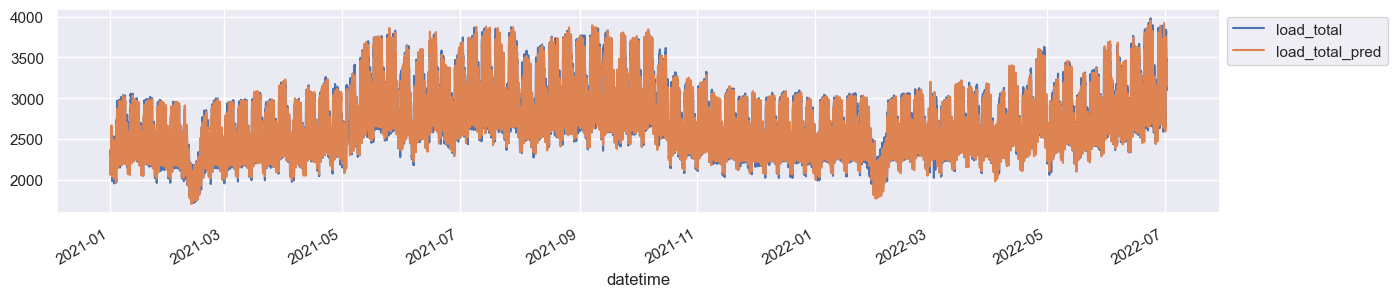

In [29]:
traindata = df_dataset.loc[:'2020'].copy()
testdata = df_dataset.loc['2021':].copy()


LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['load_total_untrended'])

testdata['load_total_pred'] = LGB_model.predict(testdata[list_feat])
testdata['load_total_pred'] = testdata['load_total_pred'] / (1-growth_rate*testdata['delta_time'])

errors = abs(testdata['load_total_pred'] - testdata['load_total'])

RSQUARED = r2_score(testdata['load_total'], testdata['load_total_pred'])
MAE = mean_absolute_error(testdata['load_total'], testdata['load_total_pred'])

print("R SQUARED: "+str(round(RSQUARED,3)))
print("MAE: "+str(round(MAE,3)))

#testdata[['load_total', 'load_total_pred']].iplot()
testdata[['load_total', 'load_total_pred']].plot(figsize=(15,3))
plt.legend(bbox_to_anchor=(1.00, 1.00))